# X-Ray Data Analysis 

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import pandas as pd
from scipy.ndimage import gaussian_filter as gf
from collections import defaultdict
import re
import gued
import time
from scipy.optimize import curve_fit, dual_annealing, differential_evolution

## Load Experimental Data

In [15]:
f1 = 'QD_ps_run187to192_scaled.npz'
#This unpacks everything from the small data file produced in the processor script
hf1 = np.load(f1)
for item in hf1:
	print(item)
	exec('%s = np.array(hf1[item])' %str(item))
    
# print(errors.shape)
# print(ibpdiffs.shape)
# print(q_bins.shape)
# print(error_rapdiffs.shape)
# print(error_aapdiffs.shape)
# print(aapdiffs.shape)
# print(time_bins.shape)
# print(phi_bins.shape)
# print(rapdiffs.shape)
print('task complete')

errors
ibpdiffs
raons
q_bins
error_rapdiffs
error_aapdiffs
aapdiffs
time_bins
phi_bins
raoffs
rapdiffs
task complete


### Apply Moving Average

In [16]:
sz = np.shape(raons) # sz[0] - size of qbins , sz[1] - size of tbins

rapdiffs_movmean = np.zeros((sz[0],sz[1]))

for i in range(0,sz[1]):
     rapdiffs_movmean[:,i] = pd.Series(rapdiffs[:,i]).rolling(window=3,axis=0).mean()

C:\Users\laure\AppData\Local\Temp\ipykernel_5476\2247553891.py:6: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  rapdiffs_movmean[:,i] = pd.Series(rapdiffs[:,i]).rolling(window=3,axis=0).mean()


### Plot 1D Q Lineouts

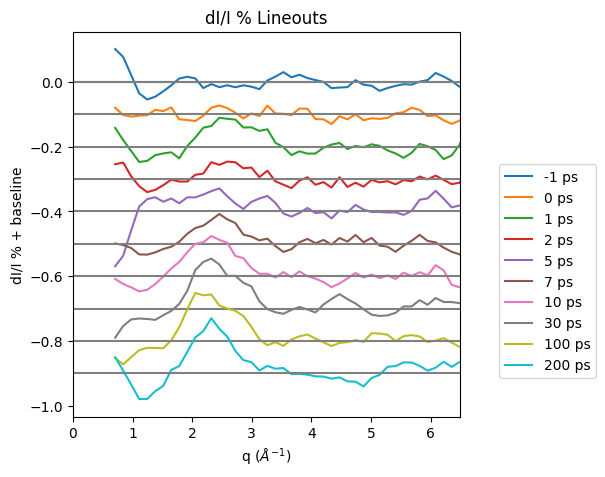

In [17]:
plt.figure(figsize=(5,5))
#for i in range(0, rapdiffs[0,:].size):
b = 0
j = 0   
#for i in range(1,2):
for i in [0,1,2,3,6,8,11,12,13,14]:
    j +=  1
    #plt.errorbar(q_bins,(rapdiffs_movmean[:,i]) + b, yerr = error_rapdiffs[:,i], label = '%0.0f ps' % time_bins[i]) 
    plt.plot(q_bins,(rapdiffs_movmean[:,i]) + b, label = '%0.0f ps' % time_bins[i])
    plt.axhline(y=b,color='grey')
    b += -0.1
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('dI/I % + baseline')
plt.title('dI/I % Lineouts')
plt.xlim([0,6.5])
#plt.ylim([-0.05,0.05])
plt.axhline(y=0, color='grey')
#plt.legend(loc='best')
plt.legend(loc=(1.1,0.1))
plt.show()
#plt.savefig('CHD_radial_average.png')

### Plotting Smoothed Experimental Data

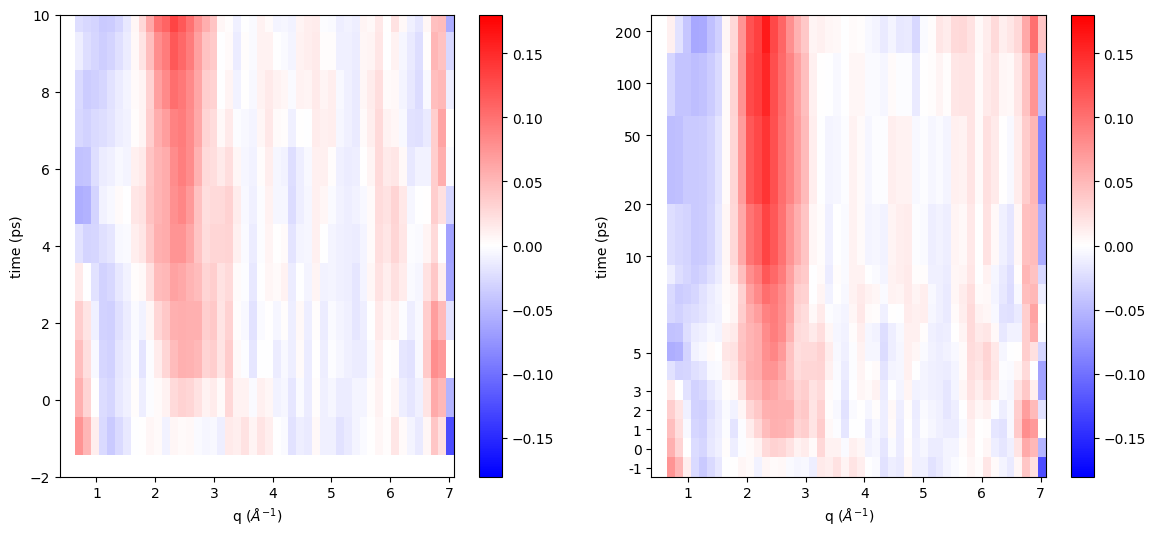

In [18]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('time (ps)')
#plt.title('dI/I: QC, moving average applied in q and Gaussian filter in time')
plt.pcolormesh(q_bins,time_bins,(gf(rapdiffs_movmean,(0,1))).T, cmap = 'bwr')
#plt.pcolormesh( q_bins,time_bins, np.transpose( gf(rapdiffs_movmean,(0,1))), cmap = 'bwr')
plt.clim(-0.18, 0.18)
# plt.xlim([-2, 20])
plt.ylim(-2,10)
#plt.yticks([0,25,50,75,100,125,150])
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.colorbar()

plt.subplot(1,2,2)
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('time (ps)')
#plt.title('dI/I: QC, moving average applied in q and Gaussian filter in time')
plt.pcolormesh(q_bins,time_bins,(gf(rapdiffs_movmean,(0,1))).T, cmap = 'bwr')
plt.clim(-0.18, 0.18)
# plt.xlim([-2, 20])
plt.yscale('symlog', linthresh=10)
custom_ticks = [-1, 0, 1, 2, 3, 5, 10, 20, 50, 100, 200]  # Add ticks between 0 and 10
plt.yticks(custom_ticks, labels=custom_ticks)
plt.colorbar()
plt.show()


## Load Trajectory Data
Loads in data from an h5 file that was create using the `Process_Trajectories.py` program that takes xyz trajectory files and calculates scattering patterns for each structure

In [29]:
inv_angs = '($\mathrm{\AA}^{-1}$)'
angs = '($\mathrm\{\AA})'

def load_trajectory_h5(file_name, group_name):
    """
    Reads an HDF5 file and groups datasets by their numeric run ID (e.g., '0014').
    
    ARGUMENTS:
    
    file_name (str):
        Name and path to the HDF5 file to read from.
    group_name (str):
        The name of the group to search in the HDF5 file.
    
    RETURNS:
    
    A dictionary where the keys are run IDs (e.g., '0014') and the values 
    are dictionaries with dataset names as keys and the dataset values as NumPy arrays.
    """
    run_dict = defaultdict(dict)  # Dictionary to group datasets by run ID
    
    # Open the HDF5 file
    with h5py.File(file_name, 'r') as f:
        if group_name not in f:
            print(f"Group '{group_name}' not found in the file.")
            return run_dict
        
        group = f[group_name]
        
        # Regex pattern to extract the numeric run ID (e.g., '0014')
        pattern = re.compile(r'run_(\d{4})')
        
        # Loop through the datasets in the group
        for dataset_name in group.keys():
            match = pattern.search(dataset_name)
            if match:
                run_id = match.group(1)  # Extract the numeric run ID (e.g., '0014')
                variable_name = dataset_name.split(f'_run_{run_id}')[0]  # Extract the variable name
                
                dataset = group[dataset_name]
                
                # Check if the dataset is scalar
                if dataset.shape == ():  # Scalar dataset
                    run_dict[run_id][variable_name] = dataset[()]  # Access scalar data
                else:  # Non-scalar dataset (array-like)
                    run_dict[run_id][variable_name] = dataset[:]  # Access array data
            else:
                print(f"Warning: Could not extract run ID from '{dataset_name}'")
    
    return dict(run_dict)  # Convert defaultdict to regular dict


def read_notes(file_path):
    with open(file_path, 'r') as file:
        text = file.readlines()
    
    traj_id = []
    idx = []
    ci_time = []
    t0 = []
    groups = []
    for line in text[1:]:  # Assuming you want to skip the first line
        string = list(map(str, line.split()))
        
        if len(string) < 4:
            continue
        temp = list(map(str, string[0].split('/')))
        traj_id.append(temp[1][5:-1])
        
        if temp[0].lower() == 'singlet_2':
            groups.append('s2')
        elif temp[0].lower() == 'singlet_3':
            groups.append('s3')
        elif temp[0].lower() == 'singlet_4':
            groups.append('s4')
        else:
            continue
        # Convert idx (string[2]) to int or np.nan if 'none'
        if string[2].lower() == 'none':
            idx.append(np.nan)
        else:
            idx.append(int(string[2]))
        
        # Convert ci_time (string[4]) to float or np.nan if 'none'
        if string[4].lower() == 'none':
            ci_time.append(np.nan)
        else:
            ci_time.append(float(string[4]))
        
        # You can extend this for other columns if needed
        # Example for t0 (string[3])
        if string[3].lower() == 'none':
            t0.append(np.nan)
        else:
            t0.append(float(string[3]))

    return groups, traj_id, idx, ci_time, t0

# Example usage:
# traj_id, idx, ci_time, t0 = read_notes('your_file.txt')


# notes_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\"
# notes_name = "QD_CI_crossing_T0_time.txt"

# notes_name = notes_path + notes_name
# groups, traj_keys, idx, ci_time, t0_val = read_notes(notes_name)
# h5_file = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\QC_Trajectories_2025-01-15_xray.h5"

# for i, group in enumerate(groups):
#     run_number = traj_keys[i]
#     dictionary = {'CI_time':ci_time[i], 't0':t0_val[i], 'idx':idx[i]}
#     gued.add_to_h5(h5_file, group, dictionary, run_number=run_number)
#     time.sleep(1)

## Load X-Ray Trajectories

In [30]:
file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "QC_Trajectories_2025-01-15_xray.h5"
print(file_name)
#gt.inspect_h5(file_name)

QC_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "s2"))
new_row = pd.DataFrame([["s2"] * len(QC_s2_traj.columns)], columns=QC_s2_traj.columns, index=["init_state"])
QC_s2_df = pd.concat([QC_s2_traj, new_row])

QC_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "s3"))
new_row = pd.DataFrame([["s3"] * len(QC_s3_traj.columns)], columns=QC_s3_traj.columns, index=["init_state"])
QC_s3_df = pd.concat([QC_s3_traj, new_row])

QC_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "s4"))
new_row = pd.DataFrame([["s4"] * len(QC_s4_traj.columns)], columns=QC_s4_traj.columns, index=["init_state"])
QC_s4_df = pd.concat([QC_s4_traj, new_row])

QC_df = pd.concat([QC_s2_df, QC_s3_df, QC_s4_df], axis=1)

file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "NB_Trajectories_2025-01-15_xray.h5"
#print(f"{len(s2_trajectories)} trajectories in this group")

NB_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "s2"))
new_row = pd.DataFrame([["s2"] * len(NB_s2_traj.columns)], columns=NB_s2_traj.columns, index=["init_state"])
NB_s2_df = pd.concat([NB_s2_traj, new_row])

NB_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "s3"))
new_row = pd.DataFrame([["s3"] * len(NB_s3_traj.columns)], columns=NB_s3_traj.columns, index=["init_state"])
NB_s3_df = pd.concat([NB_s3_traj, new_row])

NB_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "s4"))
new_row = pd.DataFrame([["s4"] * len(NB_s4_traj.columns)], columns=NB_s4_traj.columns, index=["init_state"])
NB_s4_df = pd.concat([NB_s4_traj, new_row])

NB_df = pd.concat([NB_s2_df, NB_s3_df, NB_s4_df], axis=1)


C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\QC data and code\Theory Structures\QC_Trajectories_2025-01-15_xray.h5


## Getting Averages of Simulations

In [32]:
NB_df["0000"].keys()

Index(['CI_time', 'dI_I_conv', 'dI_I_raw', 'idx', 's', 't0', 'time',
       'init_state'],
      dtype='object')

In [33]:
# Define multiple ranges
s_simu = NB_df["0000"]["s"]
min_s1, max_s1 = 1.06, 1.72
min_s2, max_s2 = 2.2, 2.82
min_s3, max_s3 = 4.85, 5.8
min_s4, max_s4 = 6.7, 7.6

traj_s = NB_s2_traj["0008"]["s"]
time_vals = NB_s2_traj["0008"]["time"] + 145
# Get the indices for each range and concatenate them

traj_indices = np.concatenate([
    np.where((traj_s > min_s1) & (traj_s < max_s1))[0],
    np.where((traj_s > min_s2) & (traj_s < max_s2))[0],
    np.where((traj_s > min_s3) & (traj_s < max_s3))[0], 
    np.where((traj_s > min_s4) & (traj_s < max_s4))[0],
])

exp_indices = np.concatenate([
    np.where((s_simu > min_s1) & (s_simu < max_s1))[0],
    np.where((s_simu > min_s2) & (s_simu < max_s2))[0],
    np.where((s_simu > min_s3) & (s_simu < max_s3))[0], 
    np.where((s_simu > min_s4) & (s_simu < max_s4))[0],
])


In [34]:
QC_s2 = pd.DataFrame.from_dict(QC_s2_traj)
QC_s2_weight = QC_s2.shape[1]
print(f"Number of trajectories for QC s2 is {QC_s2_weight}")
NB_s2 = pd.DataFrame.from_dict(NB_s2_traj)
NB_s2_weight = NB_s2.shape[1]
print(f"Number of trajectories for NB s2 is {NB_s2_weight}")

QC_s3 = pd.DataFrame.from_dict(QC_s3_traj)
QC_s3_weight = QC_s3.shape[1]
print(f"Number of trajectories for QC s3 is {QC_s3_weight}")
NB_s3 = pd.DataFrame.from_dict(NB_s3_traj)
NB_s3_weight = NB_s3.shape[1]
print(f"Number of trajectories for NB s3 is {NB_s3_weight}")

QC_s4 = pd.DataFrame.from_dict(QC_s4_traj)
QC_s4_weight = QC_s4.shape[1]
print(f"Number of trajectories for QC s4 is {QC_s4_weight}")
NB_s4 = pd.DataFrame.from_dict(NB_s4_traj)
NB_s4_weight = NB_s4.shape[1]
print(f"Number of trajectories for NB s4 is {NB_s4_weight}")


QC_s2_dI = QC_s2.loc["dI_I_raw"].mean().T
QC_s2_dI_conv = (QC_s2.loc["dI_I_conv"].mean().T)/100
QC_s2_dI_conv_all = np.array(QC_s2.loc["dI_I_conv"]/100)
QC_s2_dI_conv_err = np.std(np.array(QC_s2.loc["dI_I_conv"])/100).T
QC_s2_feat_1 = np.sum(np.abs(QC_s2_dI[traj_indices]), axis=0)
QC_s2_feat_1_conv = np.sum(np.abs(QC_s2_dI_conv[traj_indices]), axis=0)
QC_s2_late = np.mean(QC_s2_dI[:, np.where((QC_s2_traj["0014"]["time"] > 1000) & (QC_s2_traj["0014"]["time"] < 1200))[0]], axis=1)
# QC_s2_start = QC_s2_dI[:, np.where((QC_s2_traj["0014"]["time"] == 0))[0]]
# print(QC_s2_start)

QC_s2_mean = np.mean(np.abs(QC_s2_dI), axis=0)
QC_s2_t0s = np.array(QC_s2.loc["t0"])
#print(f"QC s2 t0s shape = {len(QC_s2_t0s)}")
QC_s2_CIs = np.array(QC_s2.loc["CI_time"])
QC_s2_CI = np.nanmean(np.array(QC_s2.loc["CI_time"]))
#print(f"QC s2 CIs shape = {len(QC_s2_CIs)}")

#print(QC_s2_dI.shape)
NB_s2_dI = NB_s2.loc["dI_I_raw"].mean().T
NB_s2_dI_conv = (NB_s2.loc["dI_I_conv"].mean().T)/100
NB_s2_dI_conv_all = np.array(NB_s2.loc["dI_I_conv"]/100)
NB_s2_dI_conv_err = np.std(np.array(NB_s2.loc["dI_I_conv"])/100).T
NB_s2_feat_1 = np.sum(np.abs(NB_s2_dI[traj_indices]), axis=0)
NB_s2_feat_1_conv = np.sum(np.abs(NB_s2_dI_conv[traj_indices]), axis=0)
NB_s2_late = np.mean(NB_s2_dI[:, np.where((NB_s2_traj["0107"]["time"] > 1000) & (NB_s2_traj["0107"]["time"] < 1200))[0]], axis=1)
NB_s2_mean = np.mean(np.abs(NB_s2_dI), axis=0)
NB_s2_t0s = np.array(NB_s2.loc["t0"])
#print(f"NB s2 t0s shape = {len(NB_s2_t0s)}")
NB_s2_CIs = np.array(NB_s2.loc["CI_time"])
NB_s2_CI = np.nanmean(np.array(NB_s2.loc["CI_time"]))
#print(f"NB s2 CIs shape = {len(NB_s2_CIs)}")

QC_s3_dI = QC_s3.loc["dI_I_raw"].mean().T
QC_s3_dI_conv = (QC_s3.loc["dI_I_conv"].mean().T)/100
QC_s3_dI_conv_all = np.array(QC_s3.loc["dI_I_conv"]/100)
QC_s3_dI_conv_err = np.std(np.array(QC_s3.loc["dI_I_conv"])/100).T
QC_s3_feat_1 = np.sum(np.abs(QC_s3_dI[traj_indices]), axis=0)
QC_s3_feat_1_conv = np.sum(np.abs(QC_s3_dI_conv[traj_indices]), axis=0)
QC_s3_late = np.mean(QC_s3_dI[:, np.where((QC_s2_traj["0014"]["time"] > 1000) & (QC_s2_traj["0014"]["time"] < 1200))[0]], axis=1)
QC_s3_mean = np.mean(np.abs(QC_s3_dI), axis=0)
QC_s3_t0s = np.array(QC_s3.loc["t0"])
#print(f"QC s3 t0s shape = {len(QC_s3_t0s)}")
QC_s3_CIs = np.array(QC_s3.loc["CI_time"])
QC_s3_CI = np.nanmean(np.array(QC_s3.loc["CI_time"]))
#print(f"QC s3 CIs shape = {len(QC_s3_CIs)}")

NB_s3_dI = NB_s3.loc["dI_I_raw"].mean().T
NB_s3_dI_conv = (NB_s3.loc["dI_I_conv"].mean().T)/100
NB_s3_dI_conv_all = np.array(NB_s3.loc["dI_I_conv"]/100)
NB_s3_dI_conv_err = np.std(np.array(NB_s3.loc["dI_I_conv"])/100).T
NB_s3_feat_1 = np.sum(np.abs(NB_s3_dI[traj_indices]), axis=0)
NB_s3_feat_1_conv = np.sum(np.abs(NB_s3_dI_conv[traj_indices]), axis=0)
NB_s3_late = np.mean(NB_s3_dI[:, np.where((NB_s2_traj["0107"]["time"] > 1000) & (NB_s2_traj["0107"]["time"] < 1200))[0]], axis=1)
NB_s3_mean = np.mean(np.abs(NB_s3_dI), axis=0)
NB_s3_t0s = np.array(NB_s3.loc["t0"])
#print(f"NB s3 t0s shape = {len(NB_s3_t0s)}")
NB_s3_CIs = np.array(NB_s3.loc["CI_time"])
NB_s3_CI = np.nanmean(np.array(NB_s3.loc["CI_time"]))
#print(f"NB s3 CIs shape = {len(NB_s3_CIs)}")

QC_s4_dI = QC_s4.loc["dI_I_raw"].mean().T
QC_s4_dI_conv = (QC_s4.loc["dI_I_conv"].mean().T)/100
QC_s4_dI_conv_all = np.array(QC_s4.loc["dI_I_conv"]/100)
QC_s4_dI_conv_err = np.std(np.array(QC_s4.loc["dI_I_conv"])/100).T
QC_s4_feat_1 = np.sum(np.abs(QC_s4_dI[traj_indices]), axis=0)
QC_s4_feat_1_conv = np.sum(np.abs(QC_s4_dI_conv[traj_indices]), axis=0)
QC_s4_late = np.mean(QC_s4_dI[:, np.where((QC_s2_traj["0014"]["time"] > 1000) & (QC_s2_traj["0014"]["time"] < 1200))[0]], axis=1)
QC_s4_mean = np.mean(np.abs(QC_s4_dI), axis=0)
QC_s4_t0s = np.array(QC_s4.loc["t0"])
#print(f"QC s4 t0s shape = {len(QC_s4_t0s)}")
QC_s4_CIs = np.array(QC_s4.loc["CI_time"])
QC_s4_CI = np.nanmean(np.array(QC_s4.loc["CI_time"]))

#print(QC_s2_dI.shape)
NB_s4_dI = NB_s4.loc["dI_I_raw"].mean().T
NB_s4_dI_conv = (NB_s4.loc["dI_I_conv"].mean().T)/100
NB_s4_dI_conv_all = np.array(NB_s4.loc["dI_I_conv"]/100)
NB_s4_dI_conv_err = np.std(np.array(NB_s4.loc["dI_I_conv"])/100).T
NB_s4_feat_1 = np.sum(np.abs(NB_s4_dI[traj_indices]), axis=0)
NB_s4_feat_1_conv = np.sum(np.abs(NB_s4_dI_conv[traj_indices]), axis=0)
NB_s4_late = np.mean(NB_s4_dI[:, np.where((NB_s2_traj["0107"]["time"] > 1000) & (NB_s2_traj["0107"]["time"] < 1200))[0]], axis=1)

NB_s4_mean = np.mean(np.abs(NB_s4_dI), axis=0)
NB_s4_t0s = np.array(NB_s4.loc["t0"])
#print(f"NB s4 t0s shape = {len(NB_s4_t0s)}")
NB_s4_CIs = np.array(NB_s4.loc["CI_time"])
NB_s4_CI = np.nanmean(np.array(NB_s4.loc["CI_time"]))
#print(f"NB s4 CIs shape = {len(NB_s4_CIs)}")

Number of trajectories for QC s2 is 38
Number of trajectories for NB s2 is 62
Number of trajectories for QC s3 is 25
Number of trajectories for NB s3 is 53
Number of trajectories for QC s4 is 26
Number of trajectories for NB s4 is 30


In [35]:
s2_conv_all_trajs = np.concatenate([QC_s2_dI_conv_all, NB_s2_dI_conv_all])
print(s2_conv_all_trajs.shape)

s3_conv_all_trajs = np.concatenate([QC_s3_dI_conv_all, NB_s3_dI_conv_all])
print(s3_conv_all_trajs.shape)

s4_conv_all_trajs = np.concatenate([QC_s4_dI_conv_all, NB_s4_dI_conv_all])
print(s4_conv_all_trajs.shape)

(100,)
(78,)
(56,)


## Plotting Trajectories with STD for each Initial State

(2800,)


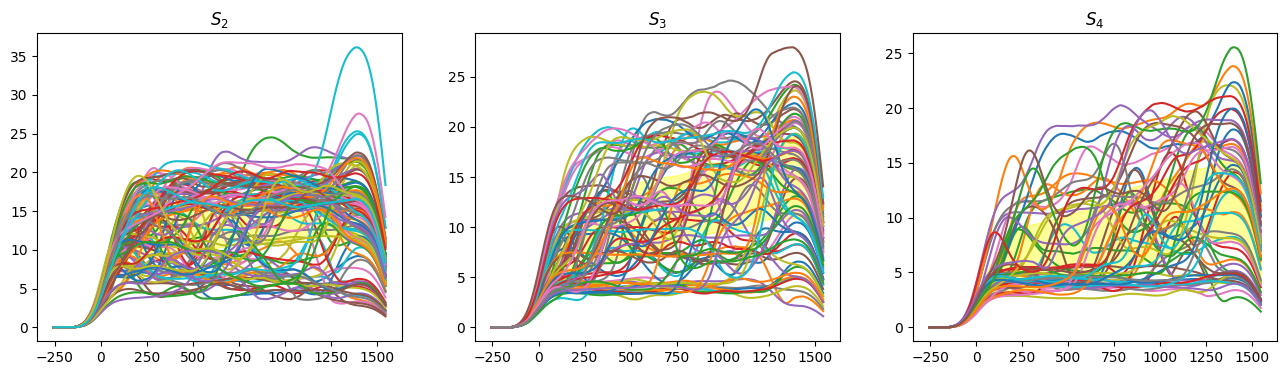

In [36]:
s2_dI_conv_all_1d = []
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
for array in s2_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s2_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s2_dI_conv_all_1d = np.array(s2_dI_conv_all_1d)
s2_dI_mean = np.mean(s2_dI_conv_all_1d, axis=0)
QC_s2_dI_std = np.std(s2_dI_conv_all_1d[:QC_s2_weight], axis=0)
NB_s2_dI_std = np.std(s2_dI_conv_all_1d[QC_s2_weight:], axis=0)
s2_dI_std = np.sqrt((QC_s2_dI_std*QC_s2_weight/(QC_s2_weight + NB_s2_weight))**2 + (NB_s2_dI_std*NB_s2_weight/(QC_s2_weight + NB_s2_weight))**2)
print(s2_dI_std.shape)
plt.fill_between(time_vals, s2_dI_mean-s2_dI_std, s2_dI_mean+s2_dI_std, color='yellow', alpha=0.4)
plt.title(r'$S_{2}$')

s3_dI_conv_all_1d = []
plt.subplot(1,3,2)
for array in s3_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s3_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s3_dI_conv_all_1d = np.array(s3_dI_conv_all_1d)
s3_dI_mean = np.mean(s3_dI_conv_all_1d, axis=0)
QC_s3_dI_std = np.std(s2_dI_conv_all_1d[:QC_s3_weight], axis=0)
NB_s3_dI_std = np.std(s2_dI_conv_all_1d[QC_s3_weight:], axis=0)
s3_dI_std = np.sqrt((QC_s3_dI_std*QC_s3_weight/(QC_s3_weight + NB_s3_weight))**2 + (NB_s3_dI_std*NB_s3_weight/(QC_s3_weight + NB_s3_weight))**2)
plt.fill_between(time_vals, s3_dI_mean-s3_dI_std, s3_dI_mean+s3_dI_std, color='yellow', alpha=0.4)
plt.title(r'$S_{3}$')

s4_dI_conv_all_1d = []
plt.subplot(1,3,3)
for array in s4_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s4_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s4_dI_conv_all_1d = np.array(s4_dI_conv_all_1d)
s4_dI_mean = np.mean(s4_dI_conv_all_1d, axis=0)
QC_s4_dI_std = np.std(s2_dI_conv_all_1d[:QC_s4_weight], axis=0)
NB_s4_dI_std = np.std(s2_dI_conv_all_1d[QC_s4_weight:], axis=0)
s4_dI_std = np.sqrt((QC_s4_dI_std*QC_s4_weight/(QC_s4_weight + NB_s4_weight))**2 + (NB_s4_dI_std*NB_s4_weight/(QC_s4_weight + NB_s4_weight))**2)
plt.fill_between(time_vals, s4_dI_mean-s4_dI_std, s4_dI_mean+s4_dI_std, color='yellow', alpha=0.4)
plt.title(r'$S_{4}$')
plt.show()
# plt.figure()
# plt.plot(time_vals, QC_s2_dI_conv_all_1d)
# plt.show()

# print(QC_s2_dI_conv.shape)

## Applying Weights to Trajectories
Applying weights to account for contributions of each initial state in terms of number of trajectories in each state

In [37]:
dI_I_all_traj = np.mean((QC_s2_dI, QC_s3_dI, QC_s4_dI, NB_s2_dI, NB_s3_dI, NB_s4_dI), axis=0)
dI_I_weighted_traj_conv = np.sum(((QC_s2_dI_conv*QC_s2_weight), (NB_s2_dI_conv*NB_s2_weight), 
                             (QC_s3_dI_conv*QC_s3_weight), (NB_s3_dI_conv*NB_s3_weight),
                             (QC_s4_dI_conv*QC_s4_weight), (NB_s4_dI_conv*NB_s4_weight)), axis=0)/204
dI_I_weighted_traj = np.sum(((QC_s2_dI*QC_s2_weight), (NB_s2_dI*NB_s2_weight), 
                             (QC_s3_dI*QC_s3_weight), (NB_s3_dI*NB_s3_weight),
                             (QC_s4_dI*QC_s4_weight), (NB_s4_dI*NB_s4_weight)), axis=0)/204
dI_I_all_traj_conv = np.mean((QC_s2_dI_conv, QC_s3_dI_conv, QC_s4_dI_conv, NB_s2_dI_conv, NB_s3_dI_conv, NB_s4_dI_conv), axis=0)
dI_I_all_traj_feat1 = np.sum(np.abs(dI_I_all_traj[traj_indices]), axis=0)
dI_I_all_traj_feat1_conv = np.sum(np.abs(dI_I_all_traj_conv[traj_indices]), axis=0)
print(dI_I_all_traj.shape)
print(dI_I_all_traj_feat1.shape)

fit_NBD = 59.2
fit_QC = 16.9


s2_weighted = np.sum(((QC_s2_dI_conv*QC_s2_weight), (NB_s2_dI_conv*NB_s2_weight)), axis=0)/(QC_s2_weight+NB_s2_weight)
dI_I_s2_feat1 = np.sum(np.abs(s2_weighted[traj_indices]), axis=0)
dI_I_s2_feat1_conv = np.sum(np.abs(s2_weighted[traj_indices]), axis=0)
print(dI_I_s2_feat1.shape)

s2_all = np.mean((NB_s2_dI, QC_s2_dI), axis=0)
s2_all_fitting_weight = np.mean((NB_s2_dI*fit_NBD, QC_s2_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s2_all_conv = np.mean((NB_s2_dI_conv, QC_s2_dI_conv), axis=0)
s2_all_conv_fitting_weight = np.sum((NB_s2_dI_conv*fit_NBD, QC_s2_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s2_fit_feat1 = np.sum(np.abs(s2_all_conv_fitting_weight[traj_indices]), axis=0)

s3_weighted = np.sum(((QC_s3_dI_conv*QC_s3_weight), (NB_s3_dI_conv*NB_s3_weight)), axis=0)/(QC_s3_weight+NB_s3_weight)
dI_I_s3_feat1 = np.sum(np.abs(s3_weighted[traj_indices]), axis=0)
dI_I_s3_feat1_conv = np.sum(np.abs(s3_weighted[traj_indices]), axis=0)
print(dI_I_s3_feat1.shape)

s3_all = np.mean((NB_s3_dI, QC_s3_dI), axis=0)
s3_all_fitting_weight = np.mean((NB_s3_dI*fit_NBD, QC_s3_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s3_all_conv = np.mean((NB_s3_dI_conv, QC_s3_dI_conv), axis=0)
s3_all_conv_fitting_weight = np.sum((NB_s3_dI_conv*fit_NBD, QC_s3_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s3_fit_feat1 = np.sum(np.abs(s3_all_conv_fitting_weight[traj_indices]), axis=0)

s4_weighted = np.sum(((QC_s4_dI_conv*QC_s4_weight), (NB_s4_dI_conv*NB_s4_weight)), axis=0)/(QC_s4_weight+NB_s4_weight)
dI_I_s4_feat1 = np.sum(np.abs(s4_weighted[traj_indices]), axis=0)
dI_I_s4_feat1_conv = np.sum(np.abs(s4_weighted[traj_indices]), axis=0)

s4_all = np.mean((NB_s4_dI, QC_s4_dI), axis=0)
s4_all_fitting_weight = np.mean((NB_s4_dI*fit_NBD, QC_s4_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s4_all_conv = np.mean((NB_s4_dI_conv, QC_s4_dI_conv), axis=0)
s4_all_conv_fitting_weight = np.sum((NB_s4_dI_conv*fit_NBD, QC_s4_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s4_fit_feat1 = np.sum(np.abs(s4_all_conv_fitting_weight[traj_indices]), axis=0)


(500, 2800)
(2800,)
(2800,)
(2800,)


## Get Product Ratios

In [40]:
s_temp, frag_dI_new = np.loadtxt("frags.txt", skiprows=1, unpack=True)
_, QC_dI_hot = np.loadtxt("QC.txt", skiprows=1, unpack=True)
_, NB_dI_hot = np.loadtxt("NB.txt", skiprows=1, unpack=True)

(500,)
(500,)


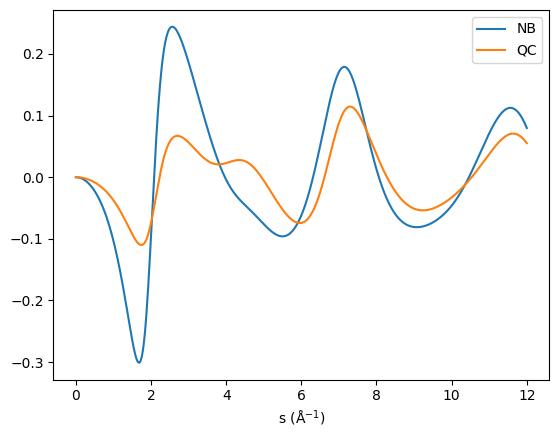

In [38]:
NB_late_all = np.array((NB_s2_late, NB_s3_late, NB_s4_late))
NB_traj_late_times = np.mean(NB_late_all, axis=0)
print(NB_traj_late_times.shape)

QC_late_all = np.array((QC_s2_late, QC_s3_late, QC_s4_late))
QC_traj_late_times = np.mean(QC_late_all, axis=0)
print(QC_traj_late_times.shape)

plt.figure()
plt.plot(traj_s, NB_traj_late_times, label="NB")
plt.plot(traj_s, QC_traj_late_times, label="QC")
#plt.plot(e_scat_s, e_scattering_mean)
plt.legend()
plt.xlabel(f"s {inv_angs}")
plt.show()

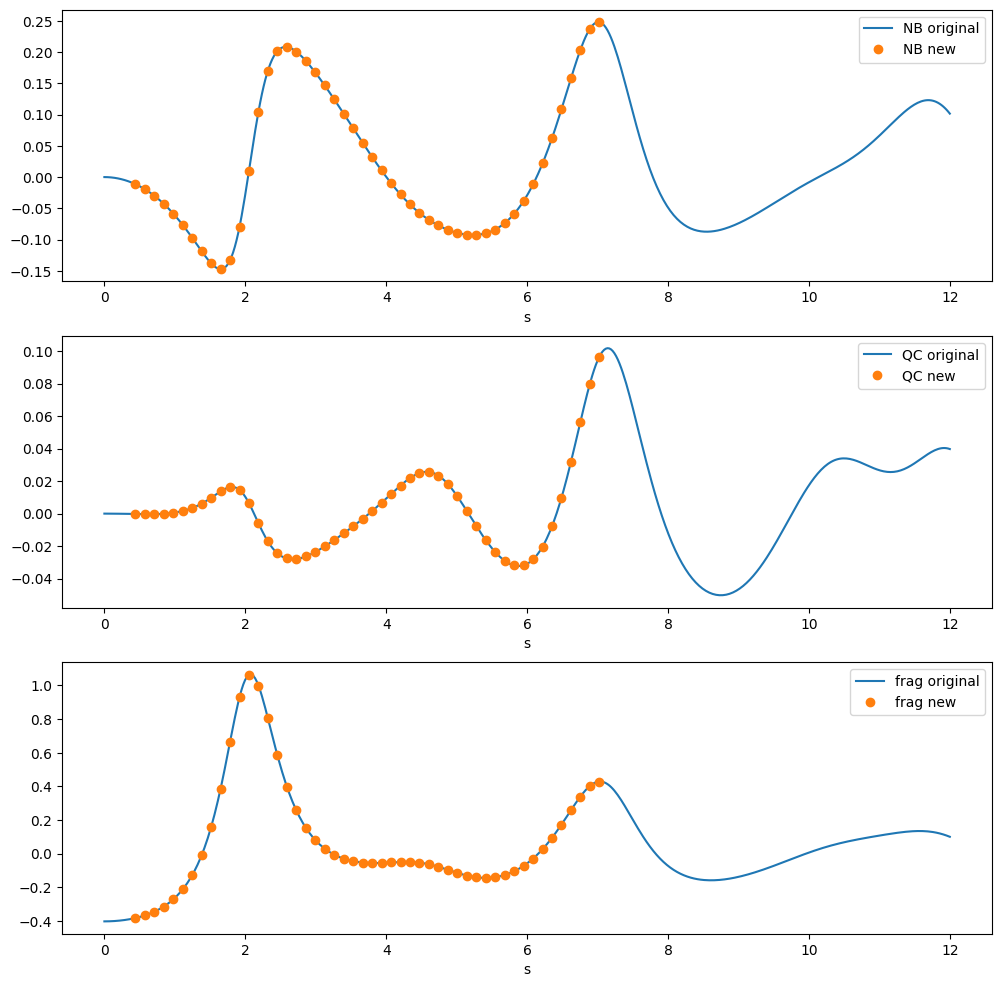

In [44]:
from scipy.interpolate import interp1d


# Original non-linear array (sine wave with 50 points)
# NB_late_new = NB_traj_late_times
# QC_late_new = QC_traj_late_times
# e_scat_sig = e_scattering_mean

NB_late_new = NB_dI_hot
QC_late_new = QC_dI_hot

# Target array length (we want 100 points in the resampled array)
array2_length = len(q_bins)

# Create an interpolation function for array1 based on its index
x_original = s_temp # Normalized indices for array1
NB_interp_func = interp1d(x_original, NB_late_new, kind='cubic')  # Cubic interpolation
QC_interp_func = interp1d(x_original, QC_late_new, kind='cubic')
frag_interp_func = interp1d(x_original, frag_dI_new, kind='cubic')
# e_interp_func = interp1d(e_scat_s, e_scattering_mean, kind='cubic', bounds_error=False, fill_value="extrapolate")
# Interpolate array1 to match the length of array2
x_target = q_bins # Normalized indices for target length
QC_late_resampled = QC_interp_func(x_target)
NB_late_resampled = NB_interp_func(x_target)
frags_late_resampled = frag_interp_func(x_target)
# e_scat_sig_resampled = e_interp_func(x_target)

# Plot the original and resampled arrays
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(s_temp, NB_late_new, "-", label="NB original")
plt.plot(q_bins, NB_late_resampled, "o", label="NB new")
plt.xlabel("s")
plt.legend()


plt.subplot(3,1,2)
plt.plot(s_temp, QC_late_new, "-", label="QC original")
plt.plot(q_bins, QC_late_resampled, "o", label="QC new")
plt.xlabel("s")
plt.legend()

plt.subplot(3,1,3)
plt.plot(s_temp, frag_dI_new, "-", label="frag original")
plt.plot(q_bins, frags_late_resampled, "o", label="frag new")
plt.xlabel("s")
plt.legend()

# plt.subplot(4,1,4)
# plt.plot(e_scat_s, e_scat_sig, "-", label="electronic original")
# plt.plot(s_simu, e_scat_sig_resampled, "o", label="electronic new")
# plt.xlabel("s")
# plt.legend()

plt.show()


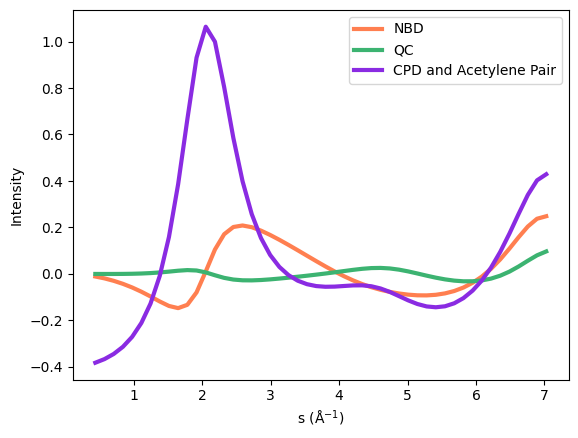

In [45]:
s_simu = q_bins
plt.figure()
plt.plot(s_simu, NB_late_resampled, color="coral", linewidth=3, label="NBD")
plt.plot(s_simu, QC_late_resampled, color="mediumseagreen", linewidth=3, label="QC")
# plt.plot(s_simu, frag_simu, label="Fragments Hot")
plt.plot(s_simu, frags_late_resampled, color="blueviolet", linewidth=3, label="CPD and Acetylene Pair")
# plt.plot(s_simu, frag_alt, label="Fragments other?")
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.legend()
plt.show()

In [46]:
# from scipy.io import savemat

# NB_late_dict = {"NB_late_line": NB_late_resampled}
# QC_late_dict = {"QC_late_line": QC_late_resampled}

# savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\NB_late_xray.mat", NB_late_dict)
# savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\QC_late_xray.mat", QC_late_dict)

## Fitting Average of Bootstrap

In [86]:
def zero_correction(x_data, y_data, theory_data):
    zero_crossings = np.where(np.diff(np.sign(theory_data)))[0]
    
    if zero_crossings.size == 0:  # No zero crossings found
        #print("Warning: No zero crossings found. Returning uncorrected data.")
        return np.zeros_like(x_data), y_data  # No baseline correction
    # for zero in zero_crossings:
    #     print(y_data[zero+10]+y_data[zero-10])
    # Proceed with zero-crossing-based correction
    #print(f"Found zeros at {x_data[zero_crossings]}")
    coeffs = np.polyfit(x_data[zero_crossings], y_data[zero_crossings], 2)
    baseline = np.polyval(coeffs, x_data)
    fixed_data = y_data - baseline
    return baseline, fixed_data


In [87]:
print(rapdiffs_movmean.shape)
print(len(q_bins))
print(time_bins)

(50, 15)
50
[-9.5000e-01  5.0000e-02  1.0500e+00  2.0500e+00  3.0500e+00  4.0500e+00
  5.0500e+00  6.0500e+00  7.0500e+00  8.0500e+00  9.0500e+00  1.0050e+01
  3.0050e+01  1.0005e+02  2.0005e+02]


In [88]:
late_data_std.shape

(47,)

In [89]:
s_min = 0.6
s_max = 7.0
s_idx = np.where((s_simu > s_min) & (s_simu < s_max))[0]

def model(x, a, b, c):
    fit_result = a*(QC_late_resampled[s_idx]) + b*(NB_late_resampled[s_idx]) + c*(frags_late_resampled[s_idx])

    return fit_result

def cost_func(params):
    return np.sum((ave_data-model(x_data, *params))**2)

def zero_fit_cost_func(params, x_data, y_data, std_data):
    theory_line = model(x_data, *params)
    _, corrected_data = zero_correction(x_data, y_data, theory_line)
    residuals = corrected_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

def weighted_cost_func(params, x_data, y_data, std_data):
    residuals = y_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

x_data = s_simu[s_idx]


late_data = np.array(np.nanmean(rapdiffs_movmean[:, -5:], axis=1))
late_data_std = np.array(np.nanstd(rapdiffs_movmean[:, -5:], axis=1))
late_data_std = late_data_std[s_idx]
print(f"shape of std of late data matrix {late_data_std.shape}")
ave_data = late_data[s_idx]
print(ave_data.shape)
print(x_data.shape)

# Gradient Based Curve Fit
bounds = ([0, 0, 0], [1, 1, 1])
#Fit the data using curve_fit
popt, pcov = curve_fit(model, x_data, ave_data, sigma=late_data_std, bounds=bounds)

print(f"curve fit found values of a, b, c = {popt}")

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *popt)


rmse = np.sqrt(np.nanmean(ave_data-perc_fit_line)**2)
print("Results from Basic Curve Fit \n")
print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n")

# Simulated Annealing 

print("Results from Dual Annealing \n")
bounds = [(0,1), (0,1), (0,1)]
result = dual_annealing(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std), no_local_search=True)
sa_params = result.x
print(f"dual annealing found results of a, b, c = {sa_params}")
print(result)

perc_QC = (sa_params[0]/sum(sa_params))*100
perc_NB = (sa_params[1]/sum(sa_params))*100
perc_frags = (sa_params[2]/sum(sa_params))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n")

# PSO
print("Results from Differential Evolution \n")
bounds = [(0,1), (0,1), (0,1)]
result = differential_evolution(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std))
sa_params = result.x
print(f"differential evolution found results of a, b, c d= {sa_params}")
print(result)

perc_QC = (sa_params[0]/sum(sa_params))*100
perc_NB = (sa_params[1]/sum(sa_params))*100
perc_frags = (sa_params[2]/sum(sa_params))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags}")

shape of std of late data matrix (47,)
(47,)
(47,)
curve fit found values of a, b, c = [1.18847912e-16 1.84524883e-01 1.09294532e-01]
Results from Basic Curve Fit 

RMSE = 0.0034599250802249235
 percent QC = 4.044930522555734e-14 
 percent NBD = 62.80214082382136 
 percent fragments = 37.19785917617859 

Results from Dual Annealing 

dual annealing found results of a, b, c = [1.80827155e-05 1.84549001e-01 1.09280846e-01]
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 148.1037674779094
       x: [ 1.808e-05  1.845e-01  1.093e-01]
     nit: 1000
    nfev: 6001
    njev: 0
    nhev: 0
RMSE = 0.007037486604223744
 percent QC = 0.006153766540840191 
 percent NBD = 62.804254290706965 
 percent fragments = 37.1895919427522 

Results from Differential Evolution 

differential evolution found results of a, b, c d= [0.         0.18452488 0.10929453]
             message: Optimization terminated successfully.
             success: True
                 fun:

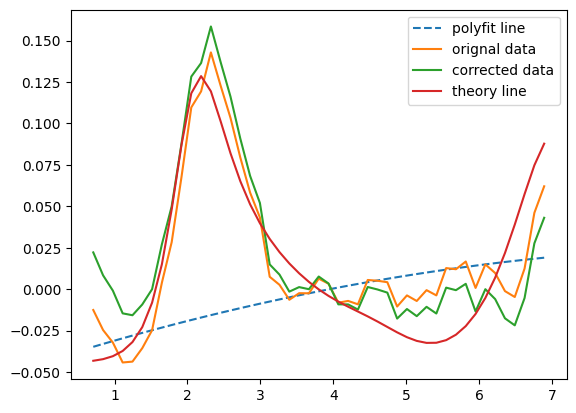

In [90]:
baseline, new_data = zero_correction(x_data, ave_data, perc_fit_line)

plt.figure()
plt.plot(x_data, baseline, "--", label="polyfit line")
plt.plot(x_data, ave_data, label="orignal data")
plt.plot(x_data, new_data, label="corrected data")
plt.plot(x_data, perc_fit_line, label="theory line")
plt.legend()
plt.show()

In [100]:
# Initialize dictionaries to store averages and standard deviations
keys = ["perc_QC", "perc_NB", "perc_frags", "excitation_perc", "fits", "rmse", "chi_sq", "corrected_data", "fails"]

# Reinitialize results dictionaries for each iteration
all_results = {key: [] for key in keys}
anneal_results = {key: [] for key in keys}
pso_results = {key: [] for key in keys}

fit_idx = np.arange(0, len(time_bins), 1)
#fit_idx = np.where(time_exp>-1)[0]
#print(fit_idx)
for idx in fit_idx:  # Loop 6 times
    late_data = np.array(rapdiffs_movmean[:, idx])  # Example dataset for each loop
    print(f"Starting fitting for round {idx}")

    y_data = late_data[s_idx]

    # Perform curve fitting
    bounds = ([0., 0., 0.], [1, 1, 1])
    popt, pcov = curve_fit(model, x_data, y_data, sigma=late_data_std, bounds=bounds)

    # Calculate percentages
    perc_QC = popt[0]
    perc_NB = popt[1]
    perc_frags = popt[2]

    perc_fit_line = model(x_data, *popt)

    # Append results to all_results
    all_results["perc_QC"].append(perc_QC/sum(popt))
    all_results["perc_NB"].append(perc_NB/sum(popt))
    all_results["perc_frags"].append(perc_frags/sum(popt))
    all_results["fits"].append(perc_fit_line)
    all_results['excitation_perc'].append(sum(popt))

    rmse = np.sqrt(np.nanmean((y_data - perc_fit_line) ** 2))
    all_results["rmse"].append(rmse)
    chi_sq = np.sum(((y_data - perc_fit_line) ** 2) / (late_data_std ** 2)) / (len(y_data) - 3)
    all_results["chi_sq"].append(chi_sq)

    # Dual Annealing fit
    result = dual_annealing(
        zero_fit_cost_func, bounds=[(0., 1)] * 3, args=(x_data, y_data, late_data_std), no_local_search=True
    )
    sa_params = result.x
    anneal_results["fails"].append(1 if result.nit == 1000 else 0)

    perc_fit_line = model(x_data, *sa_params)
    anneal_results["perc_QC"].append(sa_params[0]/sum(sa_params))
    anneal_results["perc_NB"].append(sa_params[1]/sum(sa_params))
    anneal_results["perc_frags"].append(sa_params[2]/sum(sa_params))
    anneal_results["fits"].append(perc_fit_line)
    anneal_results['excitation_perc'].append(sum(sa_params))

    # Append corrected data
    _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
    anneal_results["corrected_data"].append(corrected_data)

    # Differential Evolution fit
    result = differential_evolution(
        zero_fit_cost_func, bounds=[(0., 1)] * 3, args=(x_data, y_data, late_data_std), maxiter=2000
    )
    sa_params = result.x
    print(sa_params)
    pso_results["fails"].append(1 if result.nit == 2000 else 0)

    perc_fit_line = model(x_data, *sa_params)
    pso_results["perc_QC"].append(sa_params[0]/sum(sa_params))
    pso_results["perc_NB"].append(sa_params[1]/sum(sa_params))
    pso_results["perc_frags"].append(sa_params[2]/sum(sa_params))
    pso_results["fits"].append(perc_fit_line)
    pso_results['excitation_perc'].append(sum(sa_params))

    # Append corrected data
    _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
    pso_results["corrected_data"].append(corrected_data)

# Output combined results
# print("Combined Averages:", combined_averages)
# print("Combined Standard Deviations:", combined_stds)
print("Done")


Starting fitting for round 0
[1.42492314e-01 1.69191850e-02 9.43648570e-05]
Starting fitting for round 1
[0.00011865 0.0070613  0.007399  ]
Starting fitting for round 2
[0.00158111 0.32732887 0.0272153 ]
Starting fitting for round 3
[0.         0.13040761 0.04308615]
Starting fitting for round 4
[0.00238307 0.07347779 0.04198097]
Starting fitting for round 5
[0.001059   0.19157832 0.07267531]
Starting fitting for round 6
[0.1614788  0.08939504 0.04940295]
Starting fitting for round 7
[0.00133258 0.19961288 0.07491463]
Starting fitting for round 8
[0.00054399 0.12643593 0.07355828]
Starting fitting for round 9
[0.         0.0563837  0.05979067]
Starting fitting for round 10
[0.00089612 0.21420775 0.0816041 ]
Starting fitting for round 11
[0.         0.18671968 0.12153107]
Starting fitting for round 12
[4.07245629e-05 2.15945468e-01 1.25145930e-01]
Starting fitting for round 13
[0.         0.13440834 0.13618927]
Starting fitting for round 14
[8.29774997e-05 2.60333749e-01 9.91661425e-02]

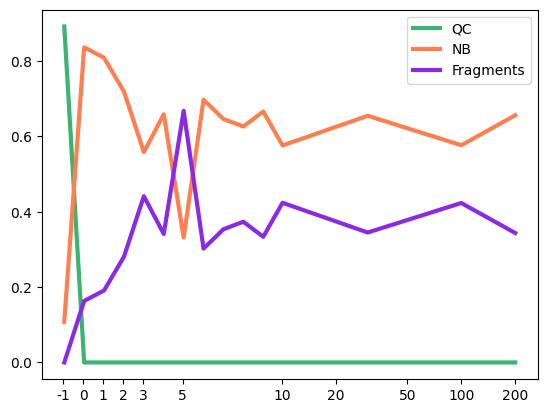

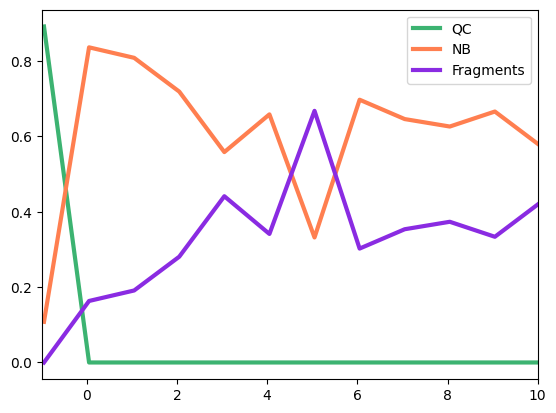

In [101]:
plt.figure()
plt.plot(time_bins, all_results["perc_QC"], color="mediumseagreen", linewidth=3, label="QC")
plt.plot(time_bins, all_results["perc_NB"], color="coral", linewidth=3, label="NB")
plt.plot(time_bins, all_results["perc_frags"], color="blueviolet", linewidth=3, label="Fragments")  
plt.legend()
plt.show()

plt.figure()
plt.plot(time_bins, all_results["perc_QC"], color="mediumseagreen", linewidth=3, label="QC")
plt.plot(time_bins, all_results["perc_NB"], color="coral", linewidth=3, label="NB")
plt.plot(time_bins, all_results["perc_frags"], color="blueviolet", linewidth=3, label="Fragments")  
plt.xlim(-1, 10)
plt.legend()
plt.show()

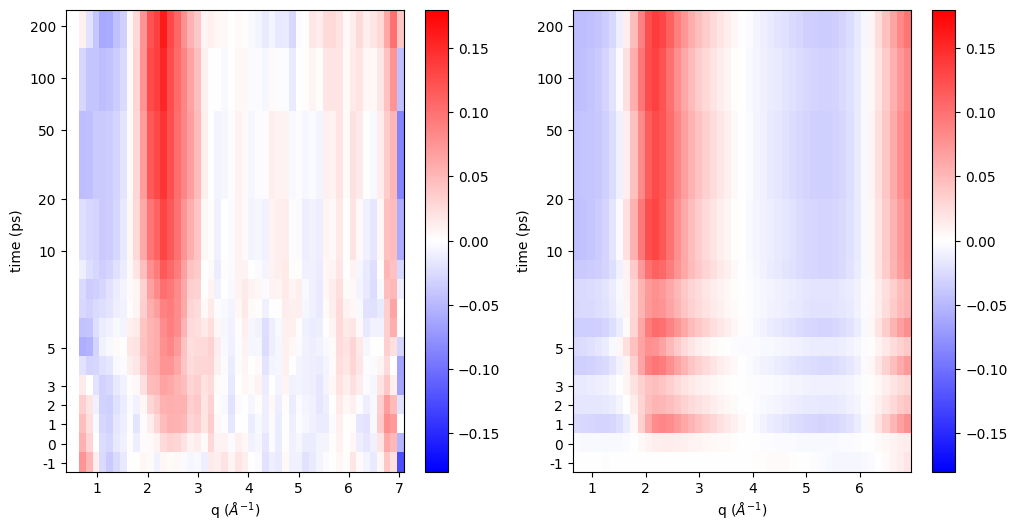

In [114]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('time (ps)')
#plt.title('dI/I: QC, moving average applied in q and Gaussian filter in time')
plt.pcolormesh(q_bins,time_bins,(gf(rapdiffs_movmean,(0,1))).T, cmap = 'bwr')
plt.clim(-0.18, 0.18)
# plt.xlim([-2, 20])
plt.yscale('symlog', linthresh=10)
custom_ticks = [-1, 0, 1, 2, 3, 5, 10, 20, 50, 100, 200]  # Add ticks between 0 and 10
plt.yticks(custom_ticks, labels=custom_ticks)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.pcolormesh(q_bins[s_idx], time_bins, np.array(all_results["fits"]), cmap="bwr")
plt.colorbar()
plt.clim(-0.18, 0.18)
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('time (ps)')
plt.yscale('symlog', linthresh=10)
custom_ticks = [-1, 0, 1, 2, 3, 5, 10, 20, 50, 100, 200]  # Add ticks between 0 and 10
plt.yticks(custom_ticks, labels=custom_ticks)

plt.show()
